In [8]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
import seaborn as sb
from utils import process_data, deviance_analysis, residual_vs_covariate



In [9]:

data, info = process_data('df-time-agg')
print(data.head())


   heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  same_side  \
0           28           20                48                52         60   
1           19           24                43                57         52   
2           20           28                48                52         44   
3           34           20                54                46         60   
4           20           26                46                54         48   

     N      person          coin  agg  from   to  mean_toss  N_throws  \
0  100  frantisekB  20DEM-silver    1     1  100       50.5       100   
1  100  frantisekB  20DEM-silver    2   101  200      150.5       100   
2  100  frantisekB  20DEM-silver    3   201  300      250.5       100   
3  100  frantisekB  20DEM-silver    4   301  400      350.5       100   
4  100  frantisekB  20DEM-silver    5   401  500      450.5       100   

   tails_tails  heads_tails  diff_side  
0           32           20         40  
1         

In [10]:


formula_cst = 'same_side+diff_side~1'
formula_person = 'same_side+diff_side~1+person'
forumula_person_time = 'same_side+diff_side~1+person+agg'
formula_person_coin = 'same_side+diff_side~1+person+coin'
formula_all_main = 'same_side+diff_side~1+person+agg+coin'
formula_nested = 'same_side+diff_side~0+person:coin'
# models with person:coin take around 8 minutes to fit (since it needs 100 iterations)

results = []
dic_cst, results_cst = deviance_analysis(data, formula_cst, 'cst_glm', force=True)
results.append(dic_cst)
dic_person, results_person = deviance_analysis(data, formula_person, 'person_glm', force=True)
results.append(dic_person)
dic_person_coin, results_person_coin = deviance_analysis(data, formula_person_coin, 'person_coin_glm', force=True)
print(dic_person_coin)
dic_person_time, results_person_time = deviance_analysis(data, forumula_person_time, 'person_time_glm', force=True)
results.append(dic_person_time)
dic_all_main, results_all_main = deviance_analysis(data, formula_all_main, 'all_main_glm', force=True)
results.append(dic_all_main)
dic_nested, results_nested = deviance_analysis(data, formula_nested, 'nested', force=False)

results_df = pd.DataFrame(results)
results_df['aic'] = results_df['aic'] - results_df['aic'].min()
print(results_df)



{'formula': '1+person+coin', 'deviance': np.float64(3724.693073285337), 'aic': np.float64(21562.08659344534), 'df_residual': np.int64(3404), 'df_model': np.int64(89)}
             formula     deviance         aic  df_residual  df_model
0                  1  4057.184449  185.599198         3493         0
1           1+person  3790.981425   13.396174         3446        47
2       1+person+agg  3775.585251    0.000000         3445        48
3  1+person+agg+coin  3717.464947   25.879696         3403        90


In [11]:
def compare_lr_test( dic, dic_restricted ):
    res = {}
    res['tested_model'] = dic['formula']
    res['restricted_model'] = dic_restricted['formula'] 

    deviance_diff = dic_restricted['deviance'] - dic['deviance']
    df_diff = dic_restricted['df_residual'] - dic['df_residual']
    p_value = 1 - stats.chi2.cdf(deviance_diff, df_diff)
    res['p_value'] = p_value

    return res

print('Table for model comparison : ')
deviance_string = results_df.to_latex(index=False, 
                columns=['formula', 'deviance', 'aic', 'df_model'], 
                header=['Model', 'Deviance', 'AIC', 'Model DF'],
                formatters={'formula': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2f}'.format,
                caption=r'Analysis of deviance of the GLM \texttt{1+person+agg+coin} model and AIC values.',
                label='tab:glm-model-comparison',
                position='htb',
                column_format='lccc')
caption_index = deviance_string.find(r'\caption')
deviance_string = deviance_string[:caption_index] + r'\centering' + '\n' + deviance_string[caption_index:]
print(deviance_string)

entries = []
entries.append( compare_lr_test( dic_person, dic_cst ) )
#entries.append( compare_lr_test( dic_person_coin, dic_person ) )
entries.append( compare_lr_test( dic_person_time, dic_person ) )
entries.append( compare_lr_test( dic_all_main, dic_person_time ) )
#entries.append( compare_lr_test( dic_nested, dic_coin_pers ) )
table = pd.DataFrame(entries)

print('LLR test table : ')
llr_string = table.to_latex(index=False, 
                columns=['tested_model', 'restricted_model', 'p_value'], 
                header=['Tested model', 'Restricted model', '$p$-value'],
                formatters={'tested_model': lambda x: r'\texttt{'+x+r'}',
                            'restricted_model': lambda x: r'\texttt{'+x+r'}'},
                float_format='{:.2e}'.format,
                caption='LRTs for the GLM fitted models.',
                label='tab:glm-lrt-comparison',
                position='htb',
                column_format='llc')
caption_index = llr_string.find(r'\caption')
llr_string = llr_string[:caption_index] + r'\centering' + '\n' + llr_string[caption_index:]
print(llr_string)



Table for model comparison : 
\begin{table}[htb]
\centering
\caption{Analysis of deviance of the GLM \texttt{1+person+agg+coin} model and AIC values.}
\label{tab:glm-model-comparison}
\begin{tabular}{lccc}
\toprule
Model & Deviance & AIC & Model DF \\
\midrule
\texttt{1} & 4057.18 & 185.60 & 0 \\
\texttt{1+person} & 3790.98 & 13.40 & 47 \\
\texttt{1+person+agg} & 3775.59 & 0.00 & 48 \\
\texttt{1+person+agg+coin} & 3717.46 & 25.88 & 90 \\
\bottomrule
\end{tabular}
\end{table}

LLR test table : 
\begin{table}[htb]
\centering
\caption{LRTs for the GLM fitted models.}
\label{tab:glm-lrt-comparison}
\begin{tabular}{llc}
\toprule
Tested model & Restricted model & $p$-value \\
\midrule
\texttt{1+person} & \texttt{1} & 0.00e+00 \\
\texttt{1+person+agg} & \texttt{1+person} & 8.72e-05 \\
\texttt{1+person+agg+coin} & \texttt{1+person+agg} & 5.00e-02 \\
\bottomrule
\end{tabular}
\end{table}



Considering the  47  most common persons
Considering the  43  most common coins
Big outliers are:  {'person[T.JanYang]': np.float64(2.5621211069316145), 'person[T.TianqiPeng]': np.float64(4.303754709833902), 'person[T.adamF]': np.float64(1.9387228518766553)}
Outlier number 1:  coin[T.0.02EUR]


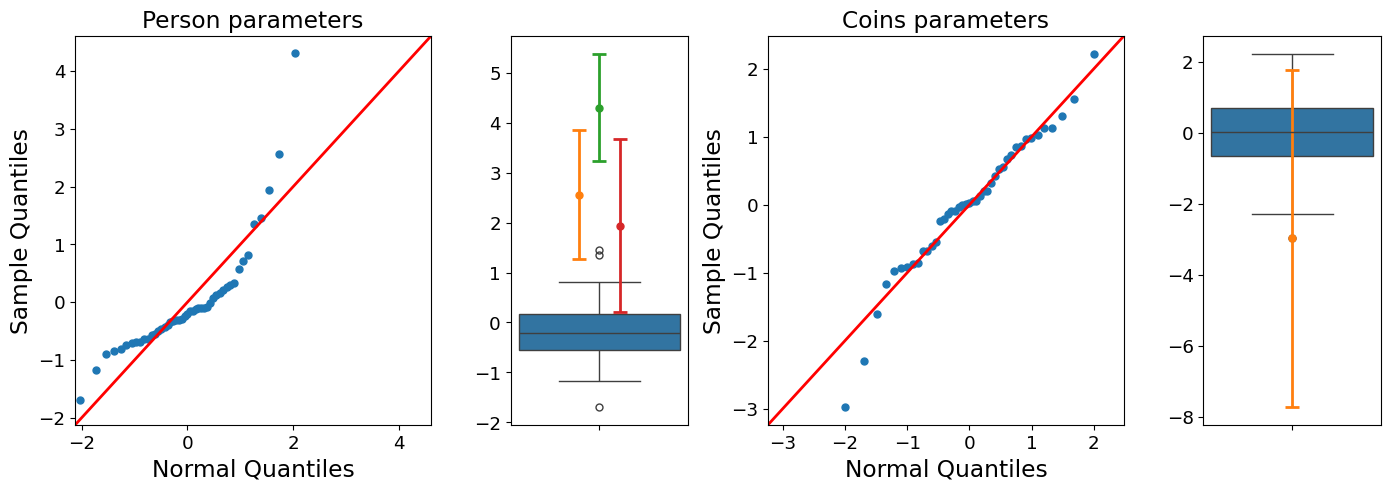

In [12]:

coefs = results_all_main.params
ci_l = coefs - results_all_main.conf_int()[0] 
ci_u = results_all_main.conf_int()[1] - coefs
width = ci_u - ci_l

# get coefficients associated to people and coins
filt_person = coefs[coefs.index.str.match(r'^person\[T\.[^\]:]+\]$')]
filt_coin = coefs[coefs.index.str.match(r'^coin\[T\.[^\]:]+\]$')]
pattern_person = r'^person\[T\.(' + '|'.join(info['common_persons']) + r')\]$'
pattern_coin = r'^coin\[T\.(' + '|'.join(info['common_coins']) + r')\]$'
common_persons = filt_person[ filt_person.index.str.match( pattern_person ) ]
common_coins = filt_coin[ filt_coin.index.str.match( pattern_coin ) ]

def norm(x, mean=None, std = None, return_params=False):
    if mean is None or std is None:
        mean = x.mean()
        std = x.std()
    if return_params:
        return (x - mean) / std, mean, std
    return (x - mean) / std

def unorm(x, mean, std):
    return x * std + mean

print('Considering the ', common_persons.count(), ' most common persons')
print('Considering the ', common_coins.count(), ' most common coins')

fig, ax = plt.subplots( 1, 4, figsize=(14, 5), width_ratios=[1, .5, 1, .5])
sm.qqplot(norm(common_persons), line='45', ax=ax[0])
ax[0].set_xlabel('Normal Quantiles')
sb.boxplot(norm(common_persons), ax=ax[1])

outliers = ax[1].get_lines()[5].get_ydata() # I found this by inspecting the boxplot
n_person, mean_person, std_person = norm(common_persons, return_params=True)
ax[1].plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing

pos = [-.1,0,.1]
k = 0
big_outliers_dic = {}
for element in outliers:
    if abs(element) in np.sort(np.abs(outliers))[:-3]:
        continue
    unorm_element = unorm(element, mean_person, std_person)
    ind = common_persons[abs(common_persons-unorm_element)<1.0e-10].index[0]
    ax[1].plot(0, element, marker='s', color='white', markersize=10)
    ax[1].errorbar(pos[k], element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_person), fmt='o', capsize=5, capthick=2)
    k += 1
    big_outliers_dic[f'{ind}'] = element
print('Big outliers are: ', big_outliers_dic)

ax[0].set_title('Person parameters')

sm.qqplot(norm(common_coins), line='45', ax=ax[2])
ax[2].set_xlabel('Normal Quantiles')
sb.boxplot(norm(common_coins), ax=ax[3])

outliers = ax[3].get_lines()[5].get_ydata()
n_coin, mean_coin, std_coin = norm(common_coins, return_params=True)
plt.plot(np.nan, np.nan) # skip blue color in cycler by plotting nothing
for i, element in enumerate(outliers):
    unorm_element = unorm(element, mean_coin, std_coin)
    ind = common_coins[abs(common_coins-unorm_element)<1.0e-10].index[0]
    ax[3].errorbar(0, element, yerr=norm(ci_u[f'{ind}'], mean=0.0, std=std_coin), fmt='o', capsize=5, capthick=2)
    print(f'Outlier number {i+1}: ', ind)

ax[2].set_title('Coins parameters')
plt.savefig('../figures/glm_unusual_params.png')


      heads_heads  tails_heads  N_start_heads_up  N_start_tails_up  same_side  \
2771           27           18                45                55         64   
1544           20           29                49                51         42   
2621           18           29                47                53         42   
2625           37           11                48                52         78   
2377           38           18                55                56         76   
2758           20           32                52                48         36   
2392           32           18                50                50         64   
2264           19           31                50                50         38   
2403           18           31                50                50         37   
2765           14           30                45                55         39   

        N      person     coin  agg  from    to  mean_toss  N_throws  \
2771  100   XiaoyiLin  0.20EUR   14 

C:\Users\Tobia\AppData\Local\Temp\ipykernel_21720\2515420613.py:59: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.savefig('../figures/glm_dev_resid_vs_covariates.png', dpi=300)


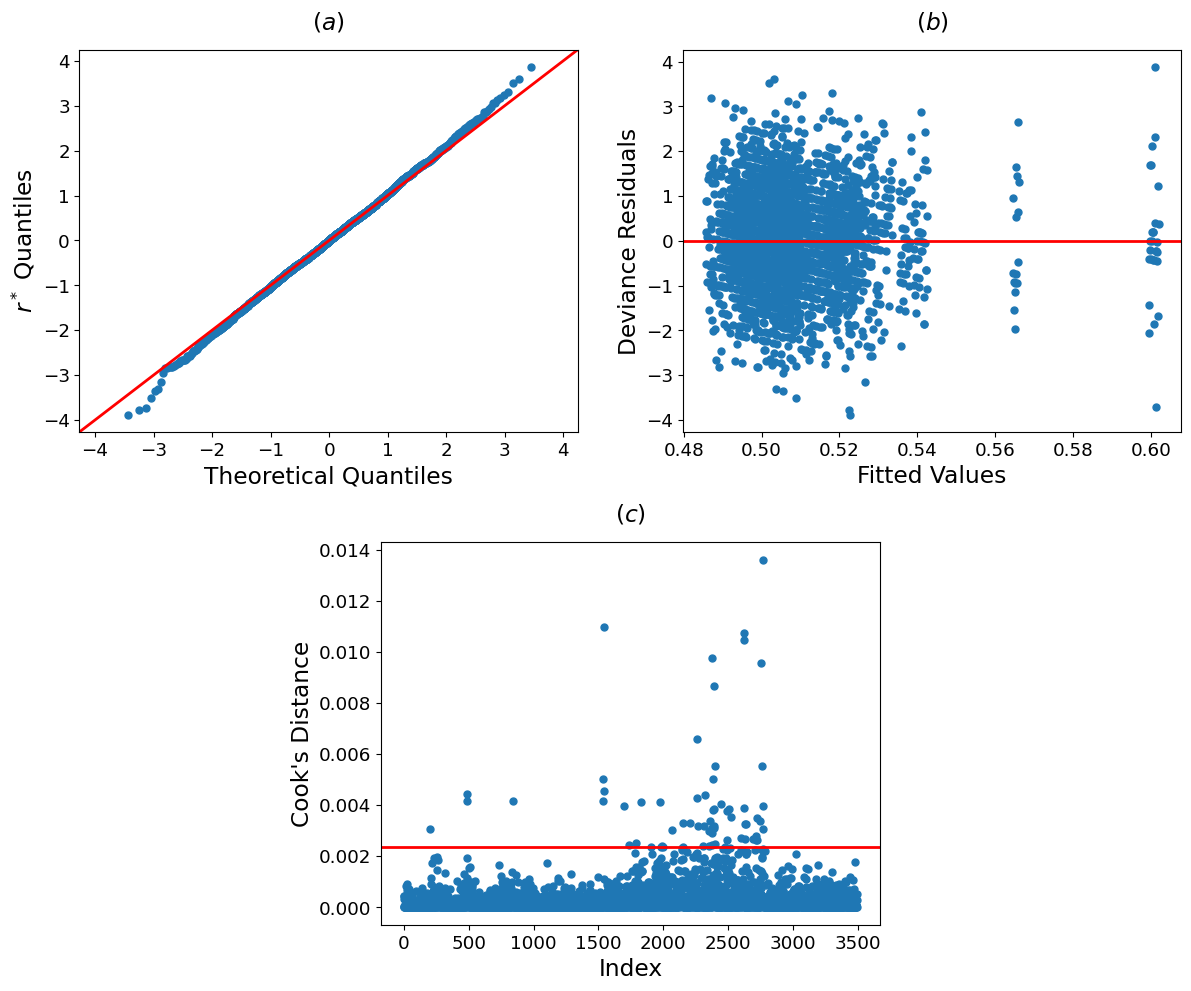

c:\Users\Tobia\miniconda3\envs\regression\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


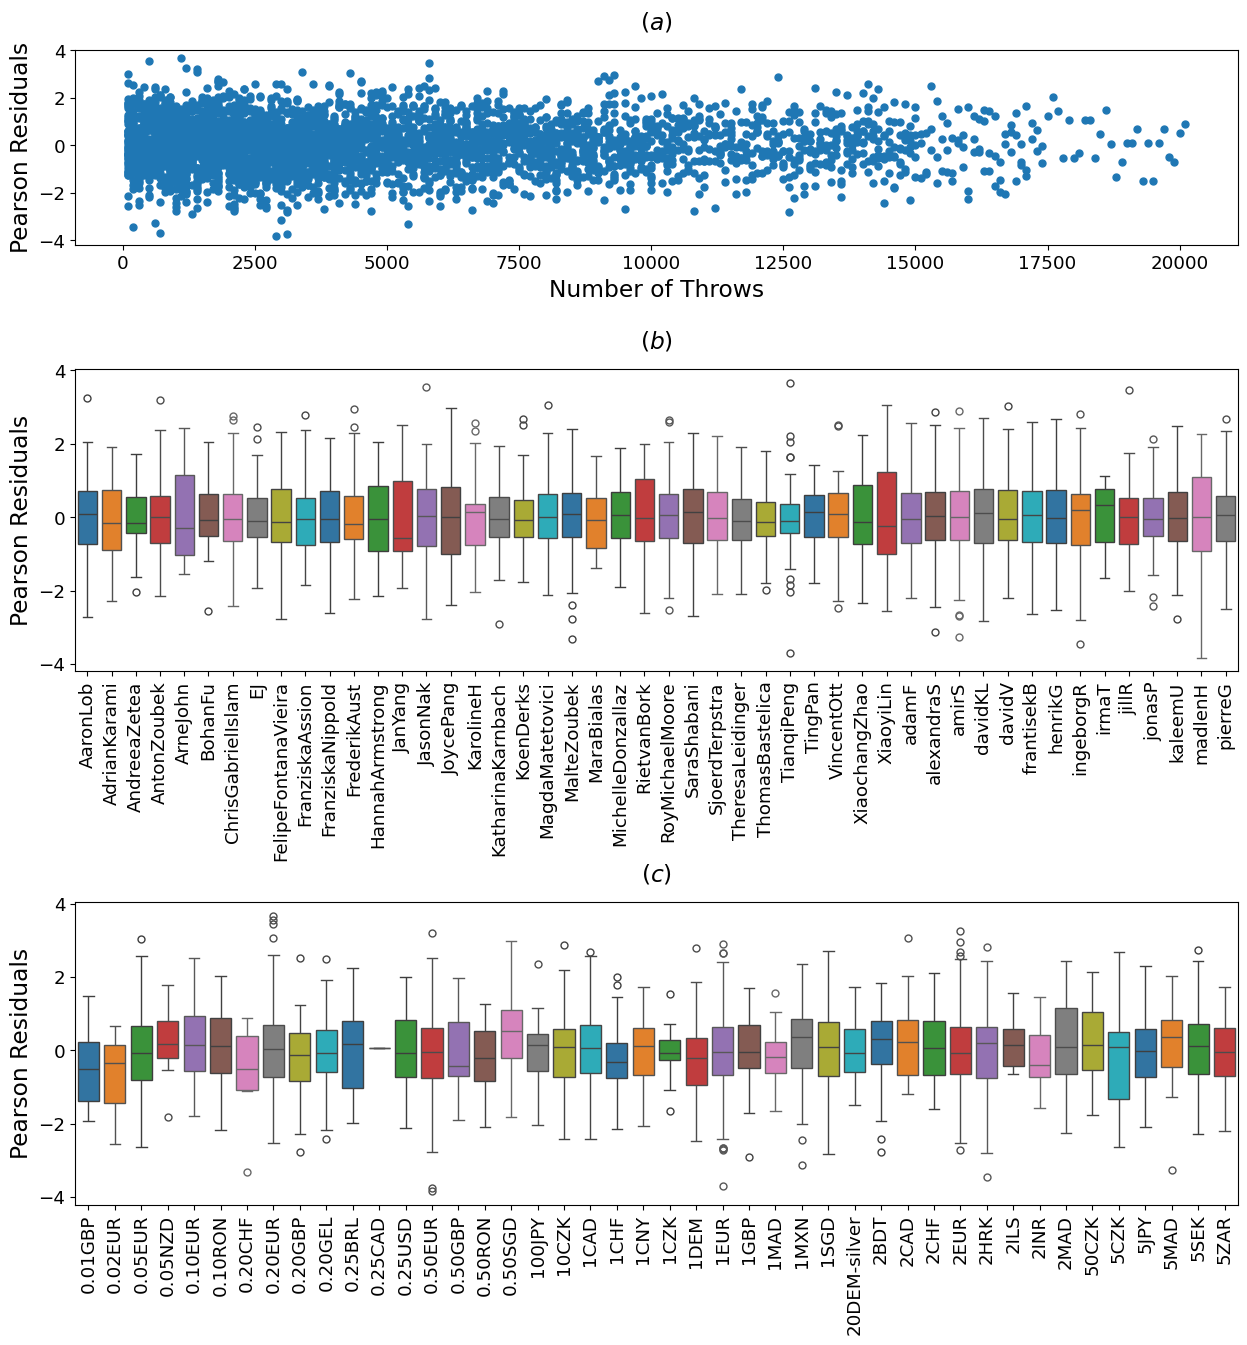

In [13]:
# Cook with davi threshold (8/(n-2p)) 

def diagnostic_plots( results, ax=None ):
    if ax is None : 
        fig = plt.figure(figsize=(12, 10))

        gs = GridSpec(2, 4, figure=fig, )
        ax1 = fig.add_subplot(gs[0,0:2])
        ax2 = fig.add_subplot(gs[0,2:])
        ax3 = fig.add_subplot(gs[1,1:-1])
    else : 
        ax1, ax2, ax3 = ax

    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    #print(max(leverage))
    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)
    
    influence = {}
    influence['davison_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance[0]

    sm.qqplot(influence['davison_resid'], line ='45', ax=ax1)
    ax1.set_ylabel('$r^*$ Quantiles')
    ax1.set_title('$(a)$', pad=15)

    fitted = results.fittedvalues
    ax2.scatter( fitted, resid_dev )
    ax2.axhline(0, color='red')
    max_resid = max(np.abs(resid_dev))
    ax2.set_ylim(-1.1*max_resid, 1.1*max_resid)
    ax2.set_xlabel('Fitted Values')
    ax2.set_ylabel('Deviance Residuals')
    ax2.set_title('$(b)$', pad=15)

    # plot cooks distance as function of index
    threshold = 8 / (len(fitted) - 2*results.df_model)
    ax3.scatter( range(len(influence['cooks_d'])), influence['cooks_d'] )
    ax3.axhline(threshold, color='red')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Cook\'s Distance')
    ax3.set_title('$(c)$', pad=15)

    return [ax1, ax2, ax3], influence


ax, influence = diagnostic_plots( results_person_time )
plt.savefig('../figures/glm_diagnostics.png', dpi=300)

inds = np.flip( np.argsort(influence['cooks_d']) )
print(data.iloc[inds[:10]])


ax = residual_vs_covariate( results_person_time, data )
plt.savefig('../figures/glm_dev_resid_vs_covariates.png', dpi=300)


0    0.523190
1    0.523064
2    0.522937
3    0.522811
4    0.522685
Name: up_ci, dtype: float64 0       0.523190
1       0.523064
2       0.522937
3       0.522811
4       0.522685
          ...   
3485    0.502609
3486    0.502521
3487    0.502434
3488    0.502346
3489    0.502259
Name: up_ci, Length: 3489, dtype: float64


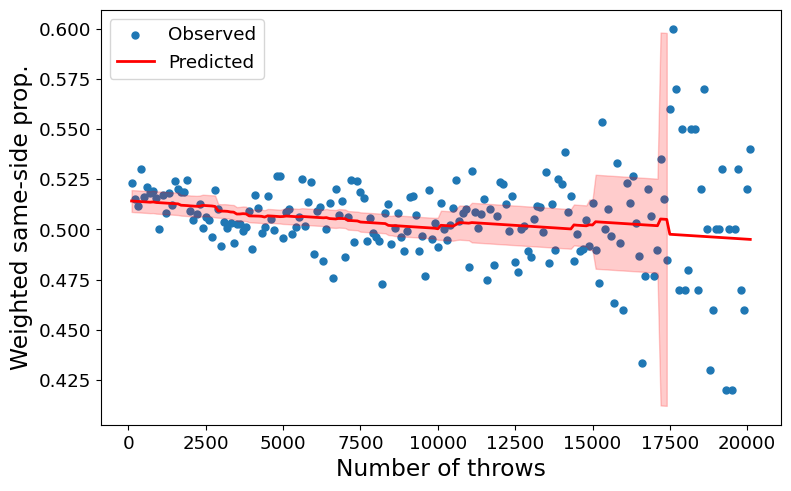

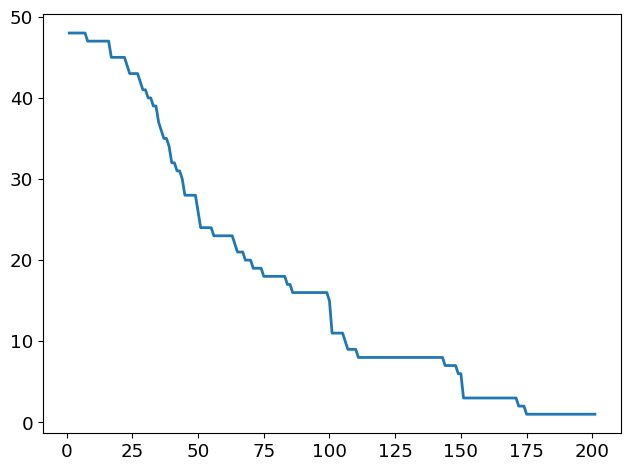

In [14]:
# add 95% CI for the predicted values (since number of people decreases with flips)
from scipy.stats import t

prediction = results_person_time.predict(data)
wheighted_prediction = (prediction * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum()
pred_se = prediction.groupby(data['agg']).std() / np.sqrt(data['N_throws'].groupby(data['agg']).count())

data['up_ci'] = results_person_time.get_prediction().summary_frame()['mean_ci_upper']
print(data['up_ci'].head(), data['up_ci'].head(-5))
#data['low_ci'] = results_person_time.get_prediction().summary_frame()['mean_ci_lower']
#print(data['low_ci'].head())
#print('\n Hey', up_ci[:5], low_ci[:5], data['prediction_ste'].head(), '\n hey')
#up_ci = (data['up_ci'] * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum() #/ np.sqrt(data['N_throws'].groupby(data['agg']).count())
#low_ci = (data['low_ci'] * data['N_throws']).groupby(data['agg']).sum() / data['N_throws'].groupby(data['agg']).sum() #/ np.sqrt(data['N_throws'].groupby(data['agg']).count())


#std_bis = data['prediction_ste'].groupby(data['agg']).mean() / np.sqrt(data['N_throws'].groupby(data['agg']).count())
same_side = data.groupby('agg').agg({'same_side': 'sum'}).values
diff_side = data.groupby('agg').agg({'diff_side': 'sum'}).values 
observation = same_side / (same_side + diff_side)
cum_n_throws = 100*data['agg'].unique()

counts = data['N_throws'].groupby(data['agg']).count()
ind = np.min(np.where(counts == 1))
dfs = counts - 1
alpha = 0.05
t_factors = t.ppf(1 - alpha / 2, dfs)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.scatter(cum_n_throws, observation, label='Observed')
plt.plot(cum_n_throws, wheighted_prediction, label='Predicted', color='red')
#plt.fill_between(cum_n_throws, low_ci, up_ci, color='red', alpha=0.2)
plt.fill_between(cum_n_throws[:ind], wheighted_prediction[:ind] - t_factors[:ind]*pred_se[:ind], \
                 wheighted_prediction[:ind] + t_factors[:ind]*pred_se[:ind], color='red', alpha=0.2)
plt.legend()
plt.xlabel('Number of throws')
plt.ylabel('Weighted same-side prop.')
plt.savefig('../figures/glm_learning_effects.png', dpi=300)


plt.figure()
plt.plot(counts)
